In [3]:
pip install torch torchvision


   ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
    --------------------------------------- 4.5/204.1 MB 24.4 MB/s eta 0:00:09
   - -------------------------------------- 10.0/204.1 MB 24.9 MB/s eta 0:00:08
   --- ------------------------------------ 15.5/204.1 MB 25.0 MB/s eta 0:00:08
   ---- ----------------------------------- 21.0/204.1 MB 25.0 MB/s eta 0:00:08
   ---- ----------------------------------- 25.2/204.1 MB 24.2 MB/s eta 0:00:08
   ------ --------------------------------- 30.9/204.1 MB 23.9 MB/s eta 0:00:08
   ------- -------------------------------- 37.2/204.1 MB 24.6 MB/s eta 0:00:07
   -------- ------------------------------- 42.5/204.1 MB 24.6 MB/s eta 0:00:07
   --------- ------------------------------ 48.0/204.1 MB 24.6 MB/s eta 0:00:07
   ---------- ----------------------------- 52.7/204.1 MB 24.5 MB/s eta 0:00:07
   ----------- ---------------------------- 57.7/204.1 MB 24.5 MB/s eta 0:00:06
   ------------ --------------------------- 62.7/

In [1]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch import nn, optim
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [7]:
data_dir ="chest_xray"

import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
from torchvision import datasets
from torch import nn, optim
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


train_data = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transforms)
val_data = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=val_test_transforms)
test_data = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=val_test_transforms)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

targets = [label for _, label in train_data.imgs]
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(targets), y=targets)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"Class Weights: {class_weights}")

model = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=20):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        print(f"[Epoch {epoch+1}] Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {correct/total:.4f}")


def evaluate(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=test_data.classes))

train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10)
evaluate(model, test_loader)



Class Weights: tensor([1.9448, 0.6730])


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Bhumi/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:01<00:00, 24.6MB/s]


[Epoch 1] Train Loss: 21.7504 | Val Loss: 0.0426 | Val Acc: 1.0000
[Epoch 2] Train Loss: 14.8029 | Val Loss: 0.9972 | Val Acc: 0.6875
[Epoch 3] Train Loss: 11.1895 | Val Loss: 0.4244 | Val Acc: 0.8750
[Epoch 4] Train Loss: 9.1578 | Val Loss: 0.1379 | Val Acc: 0.9375
[Epoch 5] Train Loss: 8.2678 | Val Loss: 0.3547 | Val Acc: 0.9375
[Epoch 6] Train Loss: 8.3372 | Val Loss: 0.1308 | Val Acc: 0.9375
[Epoch 7] Train Loss: 7.5513 | Val Loss: 0.2328 | Val Acc: 0.9375
[Epoch 8] Train Loss: 5.8429 | Val Loss: 0.3129 | Val Acc: 0.9375
[Epoch 9] Train Loss: 5.7960 | Val Loss: 0.0690 | Val Acc: 1.0000
[Epoch 10] Train Loss: 4.3423 | Val Loss: 0.4093 | Val Acc: 0.9375

Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.97      0.75      0.85       234
   PNEUMONIA       0.87      0.98      0.92       390

    accuracy                           0.90       624
   macro avg       0.92      0.87      0.88       624
weighted avg       0.91      0.90      

In [9]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Validate the trained model on different data present in val folder

In [11]:
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt

model.eval()

class_names = ['NORMAL', 'PNEUMONIA']

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

def predict_image_from_path(image_path):
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(next(model.parameters()).device)

    with torch.no_grad():
        outputs = model(input_tensor)
        probs = F.softmax(outputs, dim=1)
        conf, pred = torch.max(probs, 1)

    prediction = class_names[pred.item()]
    confidence = conf.item()

    print(f"Prediction: {prediction} | Confidence: {confidence:.2f}")

    # Show image
    plt.imshow(image)
    plt.title(f"{prediction} ({confidence:.2f})")
    plt.axis("off")
    plt.show()

    return prediction, confidence


Prediction: PNEUMONIA | Confidence: 1.00


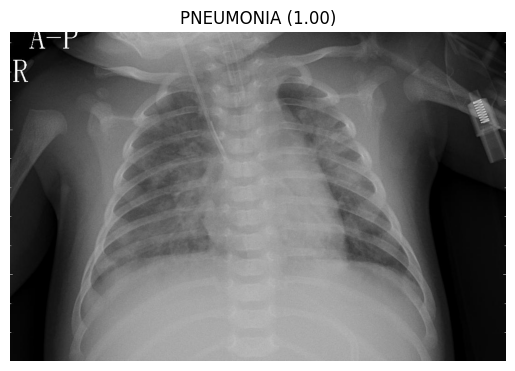

('PNEUMONIA', 1.0)

In [13]:
predict_image_from_path(r"chest_xray\val\PNEUMONIA\person1946_bacteria_4875.jpeg")

### Actual Validation from Validation Folder

Classification Report:
               precision    recall  f1-score   support

      NORMAL       1.00      0.88      0.93         8
   PNEUMONIA       0.89      1.00      0.94         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16



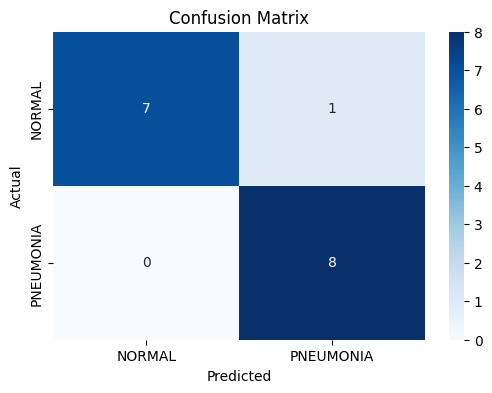


Total Misclassified: 1


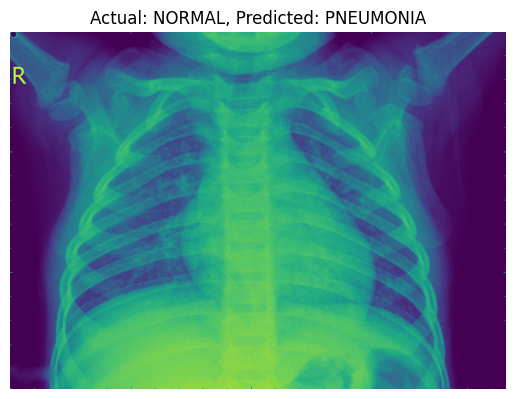

In [15]:
import os
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

val_path = r"chest_xray\val"
class_names = ['NORMAL', 'PNEUMONIA']

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

model.eval()
device = next(model.parameters()).device

y_true = []
y_pred = []

misclassified_images = []

def predict_folder(val_path):
    for class_index, class_name in enumerate(class_names):
        class_folder = os.path.join(val_path, class_name)
        for file_name in os.listdir(class_folder):
            if file_name.lower().endswith(('.jpeg', '.jpg', '.png')):
                img_path = os.path.join(class_folder, file_name)
                try:
                    image = Image.open(img_path).convert('RGB')
                    input_tensor = transform(image).unsqueeze(0).to(device)

                    with torch.no_grad():
                        outputs = model(input_tensor)
                        probs = F.softmax(outputs, dim=1)
                        pred = torch.argmax(probs, dim=1).item()

                    y_true.append(class_index)
                    y_pred.append(pred)

                    if pred != class_index:
                        misclassified_images.append((img_path, class_name, class_names[pred]))

                except Exception as e:
                    print(f"Failed to process {img_path}: {e}")

predict_folder(val_path)

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(f"\nTotal Misclassified: {len(misclassified_images)}")
for path, actual, predicted in misclassified_images[:5]: 
    img = Image.open(path)
    plt.imshow(img)
    plt.title(f"Actual: {actual}, Predicted: {predicted}")
    plt.axis('off')
    plt.show()
